## 1.Create a Spark session

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("ChicagoCrimeAnalysis").getOrCreate()

In [4]:
spark

## 2.Define the schema for loading the Chicago crime dataset (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data).

In [5]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, FloatType, TimestampType, BooleanType

In [6]:

#Defining the schema for the Chicago crime dataset
crime_schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("CaseNumber", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("PrimaryType", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("LocationDescription", StringType(), True),
    StructField("Arrest", BooleanType(), True),
    StructField("Domestic", BooleanType(), True),
    StructField("Beat", IntegerType(), True),
    StructField("District", IntegerType(), True),
    StructField("Ward", IntegerType(), True),
    StructField("CommunityArea", IntegerType(), True),
    StructField("FBICode", StringType(), True),
    StructField("XCoordinate", IntegerType(), True),
    StructField("YCoordinate", IntegerType(), True),
    StructField("Year", IntegerType(), True),
    StructField("UpdatedOn", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])




## 3.Load the Chicago crime data (you should get more than a million rows).

In [7]:
dataframe = spark.read.format("csv").option("header", "true").option("delimiter", ",").schema(crime_schema).load("Crimes_-_2001_to_Present.csv")


In [8]:
dataframe.columns

['ID',
 'CaseNumber',
 'Date',
 'Block',
 'IUCR',
 'PrimaryType',
 'Description',
 'LocationDescription',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'CommunityArea',
 'FBICode',
 'XCoordinate',
 'YCoordinate',
 'Year',
 'UpdatedOn',
 'Latitude',
 'Longitude',
 'Location']

In [9]:
dataframe.show()

+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|      ID|CaseNumber|                Date|               Block|IUCR|       PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn|    Latitude|    Longitude|            Location|
+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|11037294|  JA371270|03/18/2015 12:00:...|   0000X W WACKER DR|1153|DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|                BANK| false|   false|

## 4.Clean the data:


### a. Remove all null values.


In [10]:
from pyspark.sql.functions import col, count, when

# Use a list comprehension to count null values for each column
null_counts = [count(when(col(c).isNull(), c)).alias(c) for c in dataframe.columns]

# Use the agg function to summarize the counts for all columns
result = dataframe.agg(*null_counts)

# Collect the result as a single row
null_counts_row = result.collect()[0]

# Show the columns with null values and their counts
for col_name in dataframe.columns:
    count = null_counts_row[col_name]
    if count > 0:
        print(f"Column '{col_name}' has {count} null values.")


Column 'LocationDescription' has 11937 null values.
Column 'District' has 47 null values.
Column 'Ward' has 614849 null values.
Column 'CommunityArea' has 613476 null values.
Column 'XCoordinate' has 90138 null values.
Column 'YCoordinate' has 90138 null values.
Column 'Latitude' has 90138 null values.
Column 'Longitude' has 90138 null values.
Column 'Location' has 90138 null values.


In [11]:
dataframe = dataframe.na.drop()

#Showing the modified 'dataframe' DataFrame
dataframe.show()


+--------+----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|      ID|CaseNumber|                Date|               Block|IUCR|         PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn|    Latitude|    Longitude|            Location|
+--------+----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|12045583|  JD226426|05/07/2020 10:24:...| 035XX S INDIANA AVE|0820|               THEFT|      $500 AND UNDER|           APARTMENT| false| 

### b. Change 'Date' column data type

In [12]:
from pyspark.sql.functions import to_timestamp

#Changing 'Date' column data type
dataframe = dataframe.withColumn("Date", to_timestamp(dataframe["Date"], "MM/dd/yyyy hh:mm:ss a"))


In [13]:
#Printing the schema to verify the change
dataframe.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- CommunityArea: integer (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: integer (nullable = true)
 |-- YCoordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [14]:
#Showing the first few rows of the DataFrame with the 'Date' column converted
dataframe.show()


+--------+----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|      ID|CaseNumber|               Date|               Block|IUCR|         PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn|    Latitude|    Longitude|            Location|
+--------+----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|12045583|  JD226426|2020-05-07 10:24:00| 035XX S INDIANA AVE|0820|               THEFT|      $500 AND UNDER|           APARTMENT| false|   fa

## 5.Filter the data for last ten years.

In [15]:
#Filtering the DataFrame for records with 'Year' greater than or equal to 2013
dataframe = dataframe.filter(dataframe["Year"] >= 2013)

#Showing the filtered DataFrame
dataframe.show()


+--------+----------+-------------------+--------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|      ID|CaseNumber|               Date|               Block|IUCR|      PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn|    Latitude|    Longitude|            Location|
+--------+----------+-------------------+--------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|12045583|  JD226426|2020-05-07 10:24:00| 035XX S INDIANA AVE|0820|            THEFT|      $500 AND UNDER|           APARTMENT| false|   false| 212|   

## 6.Remove all the records with the following crime types:
##### 1.'NON-CRIMINAL (SUBJECT SPECIFIED)'
##### 2.'OTHER OFFENSE'
##### 3.'STALKING'
##### 4.'NON - CRIMINAL'
##### 5.'ARSON'

In [16]:
#Defining the list of crime types to remove
crime_types_to_remove = [
    "NON-CRIMINAL (SUBJECT SPECIFIED)",
    "OTHER OFFENSE",
    "STALKING",
    "NON - CRIMINAL",
    "ARSON"
]

#Removing records with the specified crime types
dataframe = dataframe.filter(~dataframe["PrimaryType"].isin(crime_types_to_remove))

#Showing the DataFrame with the specified crime types removed
dataframe.show()


+--------+----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|      ID|CaseNumber|               Date|               Block|IUCR|        PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn|    Latitude|    Longitude|            Location|
+--------+----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|12045583|  JD226426|2020-05-07 10:24:00| 035XX S INDIANA AVE|0820|              THEFT|      $500 AND UNDER|           APARTMENT| false|   false|

## 7.Merge the similar crime types.
### For example, change 'Primary Type' of cases that have 'Primary Type' as ‘SEX OFFENSE’ or ‘PROSTITUTION’ such that they should have the same 'Primary Type'.

In [17]:
from pyspark.sql.functions import when, col

#Defining a dictionary to specify the mappings of crime types
crime_type_mappings = {
    'CRIMINAL SEXUAL ASSAULT': 'SEX_CRIMES',
    'OBSCENITY': 'SEX_CRIMES',
    'PROSTITUTION': 'SEX_CRIMES',
    'SEX OFFENSE': 'SEX_CRIMES',
    'CRIM SEXUAL ASSAULT': 'SEX_CRIMES',
    'PUBLIC PEACE VIOLATION': 'PUBLIC INDECENCY',
    'PUBLIC INDECENCY': 'PUBLIC INDECENCY',
    'ASSAULT': 'ASSAULT',
    'BATTERY': 'ASSAULT',
    'THEFT': 'PROPERTY CRIME',
    'ROBBERY': 'PROPERTY CRIME',
    'BURGLARY': 'PROPERTY CRIME',
    'NARCOTICS': 'DRUG OFFENSE',
    'OTHER NARCOTIC VIOLATION': 'DRUG OFFENSE'
}

#Creating a new DataFrame with merged crime types using the mappings
for primary_type, merged_type in crime_type_mappings.items():
    dataframe = dataframe.withColumn(
        "PrimaryType",
        when(col("PrimaryType") == primary_type, merged_type).otherwise(col("PrimaryType"))
    )

#Showing the DataFrame with merged crime types
dataframe.show()


+--------+----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|      ID|CaseNumber|               Date|               Block|IUCR|        PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|           UpdatedOn|    Latitude|    Longitude|            Location|
+--------+----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+--------------------+------------+-------------+--------------------+
|12045583|  JD226426|2020-05-07 10:24:00| 035XX S INDIANA AVE|0820|     PROPERTY CRIME|      $500 AND UNDER|           APARTMENT| false|   false|

## 8.Analyze the data and present results:

### 1.Show year-wise trend of the crime for last ten years

In [18]:
from pyspark.sql import functions as F

#Calculating the current year
current_year = F.year(F.current_date())

#Filtering the DataFrame for the last ten years
dataframe_last_ten_years = dataframe.filter(dataframe["Year"] >= current_year - 10)

#Grouping and counting the data for the last ten years
crime_orderwise = dataframe_last_ten_years.groupBy("Year").count().orderBy("Year")
crime_orderwise.show()


+----+------+
|Year| count|
+----+------+
|2013|287822|
|2014|256123|
|2015|239889|
|2016|248589|
|2017|246560|
|2018|245378|
|2019|240849|
|2020|193864|
|2021|187552|
|2022|217404|
|2023|190540|
+----+------+



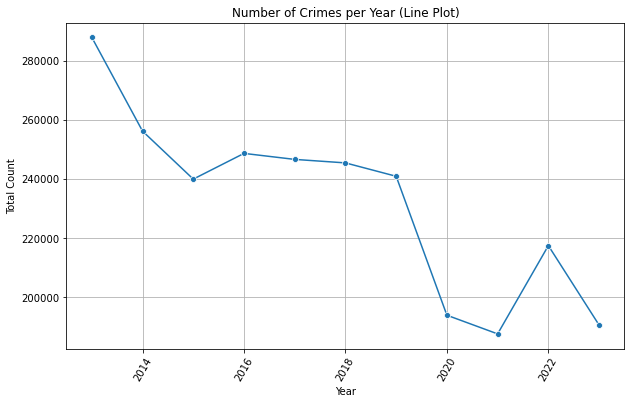

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

#Creating a Pandas DataFrame from the crime_orderwise DataFrame
crime_orderwise_df = crime_orderwise.toPandas()

#Creating a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="count", data=crime_orderwise_df, marker="o")
plt.xticks(rotation=60)
plt.xlabel("Year")
plt.ylabel("Total Count")
plt.title("Number of Crimes per Year (Line Plot)")
plt.grid()
plt.show()


### 2.Find out at which hour of the day crime is highest.

In [20]:
from pyspark.sql.functions import hour

#Extracting the hour from the 'Date' column
dataframe = dataframe.withColumn("Hour", hour("Date"))

#Grouping the data by hour and count the number of crimes for each hour
hourly_crime_counts = dataframe.groupBy("Hour").count()

#Finding the hour with the highest number of crimes
max_hourly_crime = hourly_crime_counts.orderBy("count", ascending=False).first()

#Showing the hour with the highest number of crimes
print("The hour with the highest number of crimes is", max_hourly_crime["Hour"], "o'clock with", max_hourly_crime["count"], "crimes.")


The hour with the highest number of crimes is 12 o'clock with 147571 crimes.


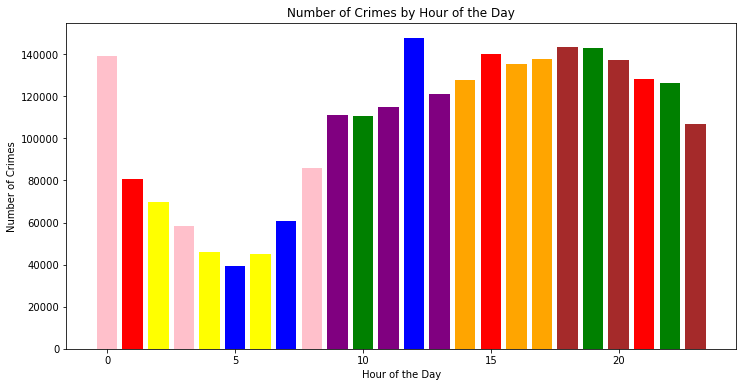

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

#Converting the DataFrame to a Pandas DataFrame
hourly_crime_counts_pd = hourly_crime_counts.toPandas()

#Defining custom colors
custom_colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'pink', 'brown']

#Plotting the graph with custom colors
plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_crime_counts_pd["Hour"], hourly_crime_counts_pd["count"], color=custom_colors)

#Adding labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Crimes")
plt.title("Number of Crimes by Hour of the Day")

#Showing the plot
plt.show()

### 3.Find top ten crimes and present them as a bar chart.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

#Grouping data by 'PrimaryType' and count the number of occurrences
top_crimes = dataframe.groupBy("PrimaryType").count()

#Ordering by count in descending order
top_crimes = top_crimes.orderBy("count", ascending=False)

#Limiting to the top ten crimes
top_ten_crimes = top_crimes.limit(10)

top_ten_crimes_df = top_ten_crimes.toPandas()

top_ten_crimes_df

,PrimaryType,count
0,PROPERTY CRIME,844479
1,ASSAULT,715807
2,CRIMINAL DAMAGE,301458
3,DECEPTIVE PRACTICE,167670
4,DRUG OFFENSE,156468
5,MOTOR VEHICLE THEFT,138967
6,CRIMINAL TRESPASS,64247
7,WEAPONS VIOLATION,62699
8,SEX_CRIMES,35382
9,OFFENSE INVOLVING CHILDREN,22491


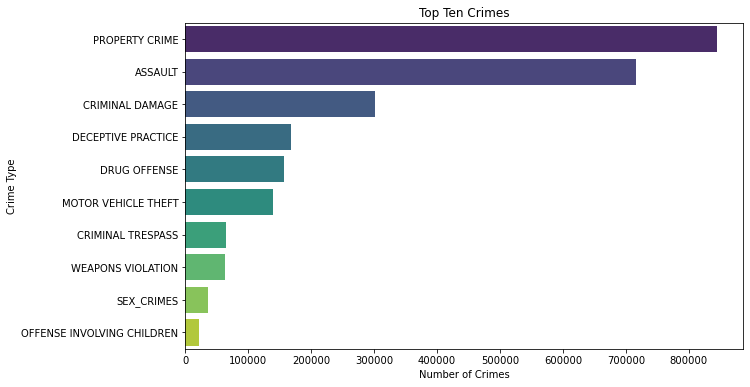

In [23]:
#Creating a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="PrimaryType", data=top_ten_crimes_df, palette="viridis")
plt.xlabel("Number of Crimes")
plt.ylabel("Crime Type")
plt.title("Top Ten Crimes")
plt.show()

In [24]:
#Stoping the Spark session
spark.stop()